In [1]:
import time
from pathlib import Path
from operator import itemgetter

import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
import os
import torch

import scSLAT
from scSLAT.model import Cal_Spatial_Net, load_anndatas, run_SLAT_mlp_AGF, spatial_match, run_SLAT, compute_lisi_for_adata, run_SLAT_AGF_contrast
from scSLAT.viz import match_3D_multi, hist, Sankey, build_3D
from scSLAT.metrics import region_statistics

In [43]:
adata_1=sc.read_h5ad(r"D:\ppppaper\SLAT\SLAT-main\SLAT-main\my_benchmark\MERFISH_14_banksy_data.h5ad")
adata_1.var_names_make_unique(join="++")
adata_1

AnnData object with n_obs × n_vars = 5926 × 155
    obs: 'cell_class', 'neuron_class', 'domain', 'Region', 'ground_truth', 'banksy', 'UMAP_1', 'UMAP_2'
    uns: 'domain_colors'
    obsm: 'X_pca', 'spatial'

In [44]:
adata_2=sc.read_h5ad(r"D:\ppppaper\SLAT\SLAT-main\SLAT-main\my_benchmark\MERFISH_19_banksy_data.h5ad")
adata_2.var_names_make_unique(join="++")
adata_2

AnnData object with n_obs × n_vars = 5803 × 155
    obs: 'cell_class', 'neuron_class', 'domain', 'Region', 'ground_truth', 'banksy', 'UMAP_1', 'UMAP_2'
    uns: 'domain_colors'
    obsm: 'X_pca', 'spatial'

In [5]:
spot_size = 35
pathology_color = [
    "#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD", "#8C564B",
    "#E377C2", "#7F7F7F", "#BCBD22", "#17BECF", "#AEC7E8", "#FFBB78",
    "#98DF8A", "#FF9896", "#C5B0D5", "#C49C94", "#F7B6D2", "#C7C7C7",
    "#DBDB8D", "#9EDAE5", "#1F9B99", "#FFCD56", "#33A02C", "#FB9A99",
    "#A6CEE3"
]

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

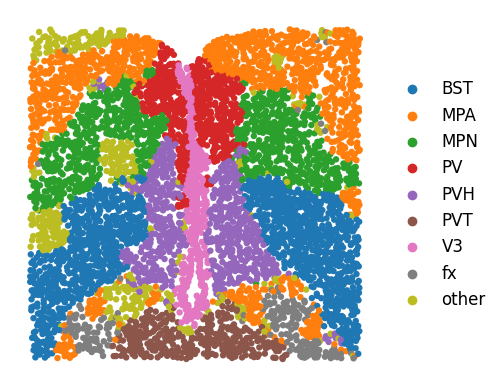

In [52]:
sc.pl.spatial(adata_1, img_key=None, color=['banksy'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

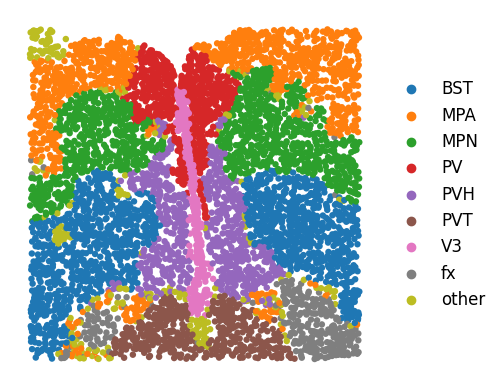

In [53]:
sc.pl.spatial(adata_2, img_key=None, color=['banksy'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

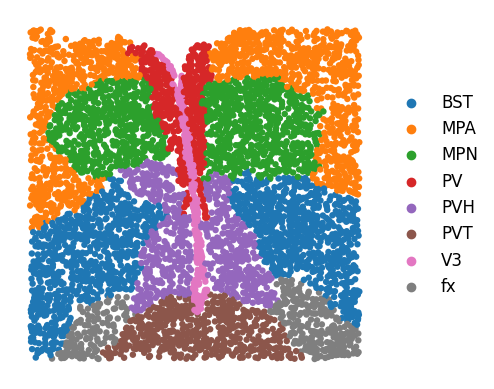

In [54]:
sc.pl.spatial(adata_2, img_key=None, color=['ground_truth'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

In [7]:
from sklearn.metrics import classification_report, confusion_matrix

# 获取真实标签和预测标签
true_labels = adata_2.obs['ground_truth']
pred_labels = adata_2.obs['banksy']

# 生成分类报告
print("Classification Report:")
print(classification_report(true_labels, pred_labels))

# 生成混淆矩阵
print("Confusion Matrix:")
print(confusion_matrix(true_labels, pred_labels))

Classification Report:
              precision    recall  f1-score   support

         BST       0.93      0.89      0.91      1381
         MPA       0.81      0.67      0.73      1165
         MPN       0.74      0.69      0.72      1094
          PV       0.65      0.86      0.74       438
         PVH       0.78      0.81      0.79       621
         PVT       0.99      0.85      0.91       491
          V3       0.82      0.91      0.86       248
          fx       0.93      0.77      0.85       365
       other       0.00      0.00      0.00         0

    accuracy                           0.79      5803
   macro avg       0.74      0.72      0.72      5803
weighted avg       0.83      0.79      0.81      5803

Confusion Matrix:
[[1234    9    7    0   72    0    0    4   55]
 [  45  778  251   19    0    0    0    5   67]
 [  23   68  758  154   53    0    0    3   35]
 [   0   20    0  377   15    0   24    0    2]
 [  26   30    7    4  502    2   18    3   29]
 [   0   13   

d:\Anaconda\envs\scSLAT\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Anaconda\envs\scSLAT\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Anaconda\envs\scSLAT\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# 计算 ARI
ari_score = adjusted_rand_score(true_labels, pred_labels)
print(f"Adjusted Rand Index (ARI): {ari_score:.8f}")

# 计算 NMI
nmi_score = normalized_mutual_info_score(true_labels, pred_labels)
print(f"Normalized Mutual Information (NMI): {nmi_score:.8f}")

Adjusted Rand Index (ARI): 0.61960471
Normalized Mutual Information (NMI): 0.65253068


In [9]:
adata_1.obsm["X_umap"] = adata_1.obs[['UMAP_1', 'UMAP_2']].values
adata_2.obsm["X_umap"] = adata_2.obs[['UMAP_1', 'UMAP_2']].values
adata_combined = adata_1.concatenate(adata_2, batch_key="slice_name", batch_categories=['slice_1','slice_2'])

d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


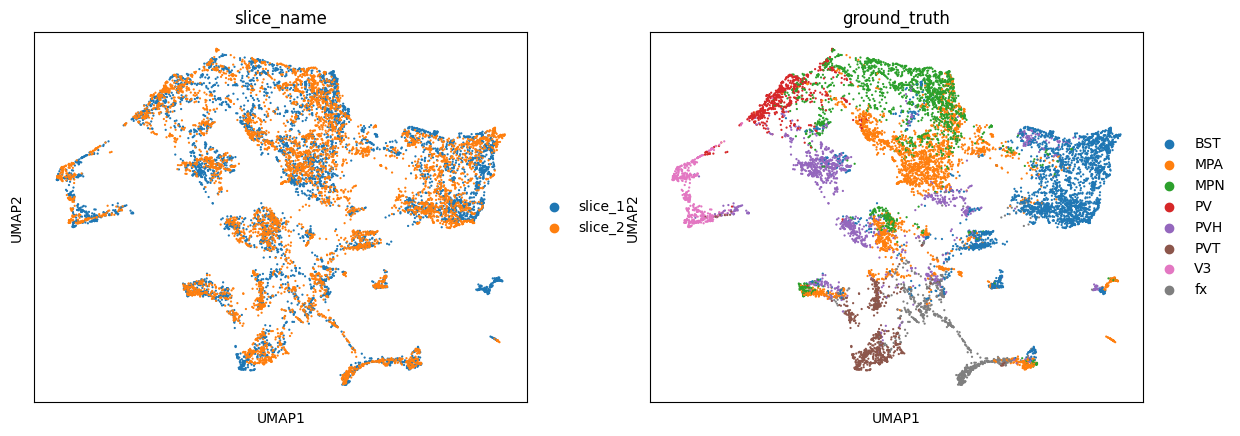

In [10]:
sc.pl.umap(adata_combined, color=['slice_name', 'ground_truth'])

In [11]:
lisi_scores = compute_lisi_for_adata(adata_combined, obsm_key='X_pca', obs_key_list=['ground_truth', 'slice_name'])
print("LISI Scores:\n", lisi_scores)

LISI Scores:
 {'cLISI': 1.4124261976187262, 'iLISI': 1.5915294280398777}


In [69]:
adata_1=sc.read_h5ad(r"D:\ppppaper\SLAT\SLAT-main\SLAT-main\my_benchmark\STARMAP_9_banksy_data.h5ad")
adata_1.var_names_make_unique(join="++")
adata_1

AnnData object with n_obs × n_vars = 1053 × 166
    obs: 'ct', 'region', 'Region', 'ground_truth', 'banksy', 'UMAP_1', 'UMAP_2'
    uns: 'ct_colors', 'region_colors'
    obsm: 'X_pca', 'spatial'

In [70]:
adata_2=sc.read_h5ad(r"D:\ppppaper\SLAT\SLAT-main\SLAT-main\my_benchmark\STARMAP_5_banksy_data.h5ad")
adata_2.var_names_make_unique(join="++")
adata_2

AnnData object with n_obs × n_vars = 1049 × 166
    obs: 'ct', 'region', 'Region', 'ground_truth', 'banksy', 'UMAP_1', 'UMAP_2'
    uns: 'ct_colors', 'region_colors'
    obsm: 'X_pca', 'spatial'

In [71]:
spot_size = 200
pathology_color = [
    "#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD", "#8C564B",
    "#E377C2", "#7F7F7F", "#BCBD22", "#17BECF", "#AEC7E8", "#FFBB78",
    "#98DF8A", "#FF9896", "#C5B0D5", "#C49C94", "#F7B6D2", "#C7C7C7",
    "#DBDB8D", "#9EDAE5", "#1F9B99", "#FFCD56", "#33A02C", "#FB9A99",
    "#A6CEE3"
]

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

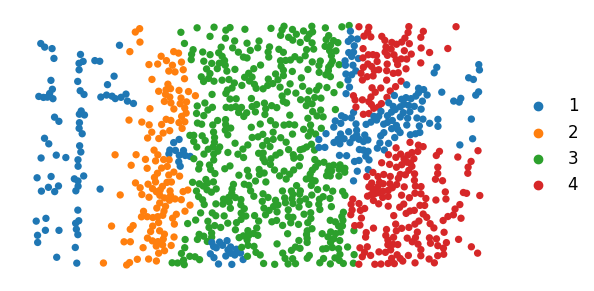

In [72]:
sc.pl.spatial(adata_1, img_key=None, color=['banksy'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

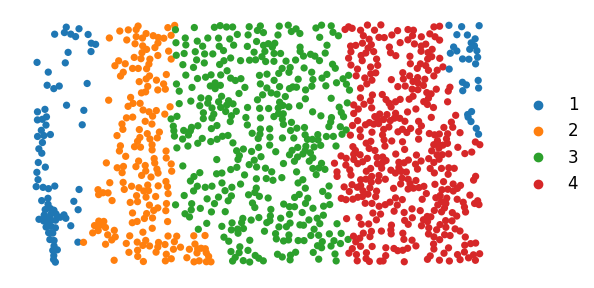

In [73]:
sc.pl.spatial(adata_2, img_key=None, color=['banksy'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

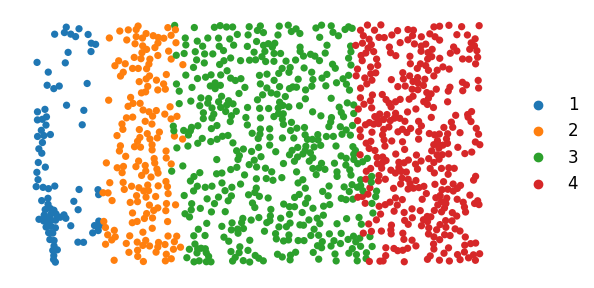

In [74]:
sc.pl.spatial(adata_2, img_key=None, color=['ground_truth'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

In [35]:
adata_1.obsm["X_umap"] = adata_1.obs[['UMAP_1', 'UMAP_2']].values
adata_2.obsm["X_umap"] = adata_2.obs[['UMAP_1', 'UMAP_2']].values
adata_combined = adata_1.concatenate(adata_2, batch_key="slice_name", batch_categories=['slice_1','slice_2'])

d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


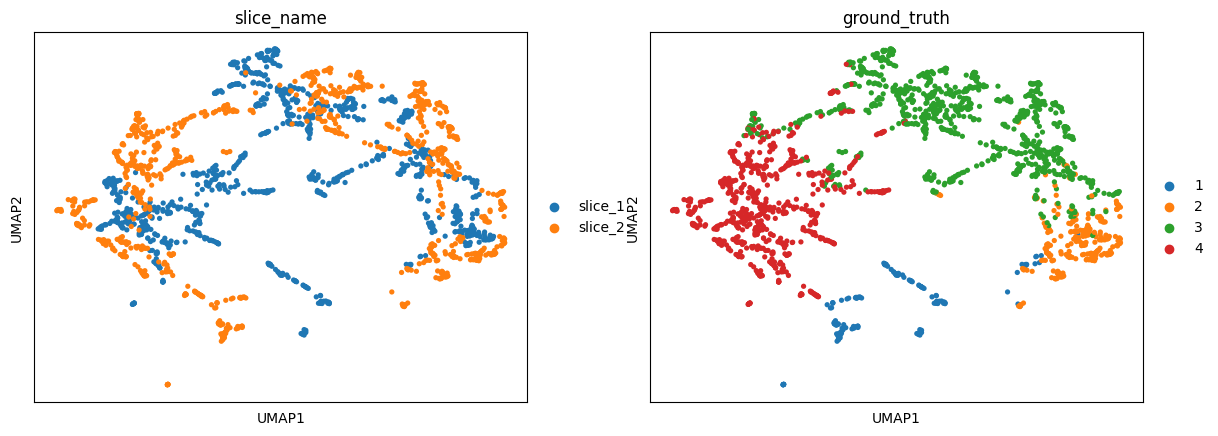

In [36]:
sc.pl.umap(adata_combined, color=['slice_name', 'ground_truth'])

In [37]:
adata_2.obs['ground_truth'] = adata_2.obs['ground_truth'].astype(str)
# 获取真实标签和预测标签
true_labels = adata_2.obs['ground_truth']
pred_labels = adata_2.obs['banksy']

# 生成分类报告
print("Classification Report:")
print(classification_report(true_labels, pred_labels))

# 生成混淆矩阵
print("Confusion Matrix:")
print(confusion_matrix(true_labels, pred_labels))

Classification Report:
              precision    recall  f1-score   support

           1       0.73      0.91      0.81        86
           2       0.86      0.95      0.91       167
           3       0.98      0.84      0.90       449
           4       0.85      0.92      0.88       347

    accuracy                           0.89      1049
   macro avg       0.86      0.90      0.87      1049
weighted avg       0.90      0.89      0.89      1049

Confusion Matrix:
[[ 78   8   0   0]
 [  0 159   8   0]
 [  0  17 375  57]
 [ 29   0   0 318]]


In [38]:
ari_score = adjusted_rand_score(true_labels, pred_labels)
print(f"Adjusted Rand Index (ARI): {ari_score:.8f}")

# 计算 NMI
nmi_score = normalized_mutual_info_score(true_labels, pred_labels)
print(f"Normalized Mutual Information (NMI): {nmi_score:.8f}")

Adjusted Rand Index (ARI): 0.71523596
Normalized Mutual Information (NMI): 0.71434641


In [40]:
lisi_scores = compute_lisi_for_adata(adata_combined, obsm_key='X_pca', obs_key_list=['ground_truth', 'slice_name'])
print("LISI Scores:\n", lisi_scores)

LISI Scores:
 {'cLISI': 1.1827491572060571, 'iLISI': 1.3296456036962083}


In [2]:
adata_3=sc.read_h5ad(r"D:\ppppaper\data\Result\MERFISH_0.14.h5ad")
adata_3.var_names_make_unique(join="++")
adata_3

AnnData object with n_obs × n_vars = 5926 × 155
    obs: 'cell_class', 'neuron_class', 'domain', 'Region', 'ground_truth', 'annotation'
    uns: 'Spatial_Net', 'domain_colors'
    obsm: 'combine', 'm0', 'm1', 'scSLAT', 'scSLAT_bks', 'spatial'

In [3]:
adata_4=sc.read_h5ad(r"D:\ppppaper\data\Result\MERFISH_0.19.h5ad")
adata_4.var_names_make_unique(join="++")
adata_4

AnnData object with n_obs × n_vars = 5803 × 155
    obs: 'cell_class', 'neuron_class', 'domain', 'Region', 'ground_truth', 'annotation', 'transferred_labels', 'transferred_labels_SLAT', 'transferred_labels_combine'
    uns: 'Spatial_Net', 'annotation_colors', 'domain_colors', 'transferred_labels_SLAT_colors', 'transferred_labels_colors', 'transferred_labels_combine_colors'
    obsm: 'combine', 'm0', 'm1', 'scSLAT', 'scSLAT_bks', 'spatial'

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

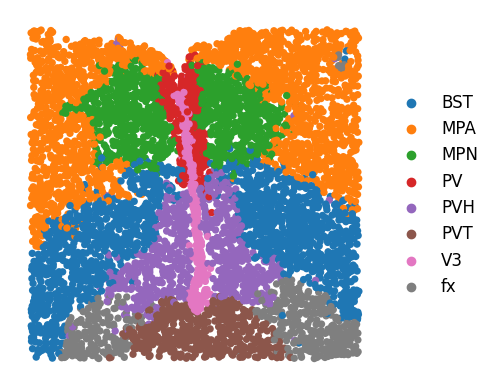

In [6]:
spot_size = 40
sc.pl.spatial(adata_4, img_key=None, color=['transferred_labels'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

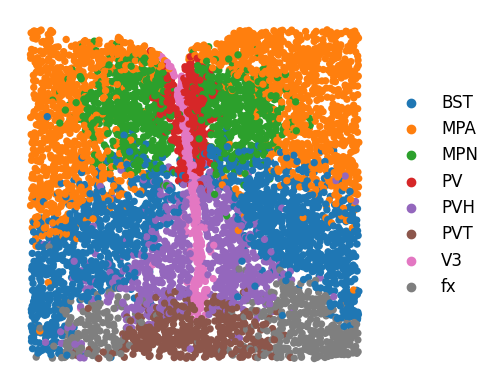

In [7]:
# adata_4.obs['transferred_labels_SLAT'] = adata_4.obs['transferred_labels_SLAT'].astype(str)
sc.pl.spatial(adata_4, img_key=None, color=['transferred_labels_SLAT'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

In [112]:
adata_4

AnnData object with n_obs × n_vars = 5803 × 155
    obs: 'cell_class', 'neuron_class', 'domain', 'Region', 'ground_truth', 'annotation', 'transferred_labels', 'transferred_labels_combine', 'transferred_labels_SLAT'
    uns: 'Spatial_Net', 'annotation_colors', 'domain_colors', 'transferred_labels_colors', 'transferred_labels_combine_colors', 'transferred_labels_SLAT_colors'
    obsm: 'combine', 'm0', 'm1', 'scSLAT', 'scSLAT_bks', 'spatial'

In [ ]:
# adata_4.write('D:\ppppaper\data\Result\MERFISH_0.19.h5ad')